In [1]:
from datetime import datetime, timedelta
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np

url = 'https://www.wahlrecht.de/umfragen/'
translations = {'Unnamed: 0': 'Date', 
                'Sonstige': 'Other', 
                'Befragte': 'Surveyed', 
                'Zeitraum': 'Time',
                'PDS': 'LINKE',
                'Linke.PDS': 'LINKE',
                'REP/DVU': 'REP',
                'Nichtwähler/Unentschl.': 'Non-Voters',
                'Datum': 'Date',
                'DIE LINKE²': 'LINKE',
                'Wahlbeteiligung': 'Surveyed'}

election_dates = {
    '1949': '1949-08-14',
    '1953': '1953-06-17',
    '1957': '1957-09-15',
    '1961': '1961-09-17',
    '1965': '1965-10-03',
    '1969': '1969-09-28',
    '1972': '1972-11-19',
    '1976': '1976-10-03',
    '1980': '1980-10-05',
    '1983': '1983-03-06',
    '1987': '1987-01-25',
    '1990': '1990-12-02',
    '1994': '1994-10-16',
    '1998': '1998-09-27',
    '2002': '2002-09-22',
    '2005': '2005-09-18',
    '2009': '2009-09-27',
    '2013': '2013-09-22',
    '2017': '2017-09-24',
}

response = requests.get(url)
soup = BeautifulSoup(response.text)
headers = soup.findAll('table')[1].findAll('thead')[0].findAll('th')

poll_institutes = []

for h in headers:
        try:
            link = h.find('a')['href']
            name = h.text
            poll_institutes.append({'name': name,
                           'link': link})
        except:
            pass

## Data retrieval and cleaning
First data is retrieved from wahlrecht.de and then cleaned ensuring integrity.

In [2]:
poll_frames = []

for poll_institute in poll_institutes:
    #read link of poll instute
    poll_url = url + poll_institute['link']

    #get link to archives
    response = requests.get(poll_url)
    soup = BeautifulSoup(response.text)

    links = [poll_institute['link']]
    
    # check for archived pages
    archive_row = False
    try:
        archive_row = soup.find("p", {"class": "navi"}).findAll("a")
        for a in archive_row:
            try:
                link = a['href']
                links.append(link)
            except:
                pass
    except AttributeError:
        pass        

    for link in links:
        poll_url = url + link

        #read survey data
        poll = pd.read_html(poll_url)[1]
        
        #rename columns
        poll.rename(columns=translations, inplace=True)

        #change type to string
        for c in poll.columns:
            if c == 'Date':
                continue
            poll[c] = poll[c].apply(str)

        #remove unused rows and columns
        get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x in y]
        unnamed_cols = get_indexes('Unnamed', poll.columns)
        poll = poll.drop(poll.columns[unnamed_cols], axis=1)
        
        if 'Time' in poll.columns:
            poll = poll[~(poll['Time'] == 'Bundestagswahl')]

        last_row = poll[pd.isna(poll['Date']) | (poll['Date'] == 'Datum')].index[0]-2
        poll = poll.iloc[:last_row]

        #add institute name and clean format
        poll['Institute'] = poll_institute['name']
        
        if 'Surveyed' in poll.columns:
            poll['Surveyed'] = poll['Surveyed'].apply(lambda x: x.replace('.', '')\
                                                      .replace('?', '').replace('nan', '')\
                                                     .replace('O • ', '').replace('~', ''))

        for c in poll.columns:
            if c in ['Date', 'Surveyed', 'Time', 'Institute']:
                continue
            poll[c] = poll[c].apply(lambda x: x.replace(',', '.').replace('%', ''))

        poll_frames.append(poll)
    
all_polls = pd.concat(poll_frames, ignore_index=True)

# reorder columns
cols = all_polls.columns.tolist()
si = cols.index('Other')
cols = cols[:si] + cols[si+4:] + cols[si:si+4]

all_polls = all_polls[cols]

# format dates
proper_dates = all_polls['Date'].apply(lambda x: x[0].isnumeric())
all_polls = all_polls[proper_dates]
all_polls['Date'] = all_polls['Date'].apply(lambda x: x.replace('*', ''))
all_polls['Date'] = pd.to_datetime(all_polls['Date'], dayfirst=True)


# tidy up poll results where ranges are reported (x-y)
cols = list(all_polls.columns)
cols = cols[1:cols.index('Other')+1]

def split_ranges(x):
    x = str(x)
    if not x[0].isnumeric():
        return np.NaN
    
    if '–' in x:
        splitter = '–'
    else:
        splitter = '-'
        
    x = x.split(splitter)
    
    if len(x) == 2:
        x = (float(x[0]) + float(x[1])) / 2
        return x
    
    else:
        return x[0]

# set 'nan' strings to np.NaN
def clear_nan(x):
    if x == 'nan':
        return np.NaN
    else:
        return x

for c in cols:
    split = all_polls[c].apply(split_ranges)
    all_polls[c] = split
    
all_polls['Time'] = all_polls['Time'].apply(clear_nan)

#----------ELECTION DATA-----------
elections = pd.read_html('https://www.wahlrecht.de/ergebnisse/bundestag.htm')[1]
cols = elections.columns[1::2]
elections = elections[cols]
elections.columns = elections.columns.droplevel(1)
cols = list(elections.columns)
cols = cols[:-1] + list(['Parteien'])
elections.columns = cols
elections.set_index('Parteien', inplace=True)
elections.rename(columns={'2017*': '2017'}, inplace=True)

def remove_non_numeric(x):
    new_x = ''
    x = str(x)
    for c in x:
        if c.isnumeric() and ord(c) < 128:
            new_x = new_x + c
    
    if len(new_x) > 1:
        new_x = new_x[:-1] + '.' + new_x[-1:]
    
    return new_x

for c in elections.columns:
    elections[c] = elections[c].apply(remove_non_numeric)

elections.rename(columns=election_dates, inplace=True)    
    
elections = elections.T.reset_index()
elections.rename(columns=translations, inplace=True)
elections['Institute'] = 'Election'
elections.rename(columns={'index': 'Date'}, inplace=True)

#format date
elections['Date'] = pd.to_datetime(elections['Date'])

#concat with polls
all_data = pd.concat([all_polls, elections], ignore_index=True)

#order columns
cols = all_data.columns.tolist()
si = cols.index('Other')
cols = cols[:si] + cols[si+4:] + cols[si:si+4]
all_data = all_data[cols].fillna('')
all_data.to_csv('./data/polls_and_elections.csv', index=False)

## Data Normalisation
Dates are normalised to calculate moving averages for weeks, semi-months and months.

In [3]:
import calendar

data = pd.read_csv('./polls_and_elections.csv', parse_dates=[0])
data.drop(columns=['Surveyed', 'Time'], inplace=True)
data = data.sort_values('Date', ascending=False)

# funtion to set all dates to respective end of week
def date_to_weekend(day):
    return day - timedelta(days=day.weekday()) + timedelta(days=6)

def date_to_semi_month(day):
    if day.day <= 15:
        new_day = 15
    else:
        new_day = calendar.monthrange(day.year, day.month)[1] 
    day = day - timedelta(days=day.day) + timedelta(days=new_day)
    return day

def date_to_month(day):
    new_day = calendar.monthrange(day.year, day.month)[1]
    day = day - timedelta(days=day.day) + timedelta(days=new_day)
    return day

# add normalised dates
data['Month'] = data['Date'].apply(date_to_month)
data['Semi Month'] = data['Date'].apply(date_to_semi_month)
data['Week'] = data['Date'].apply(date_to_weekend)

## Data Visualisation

[]

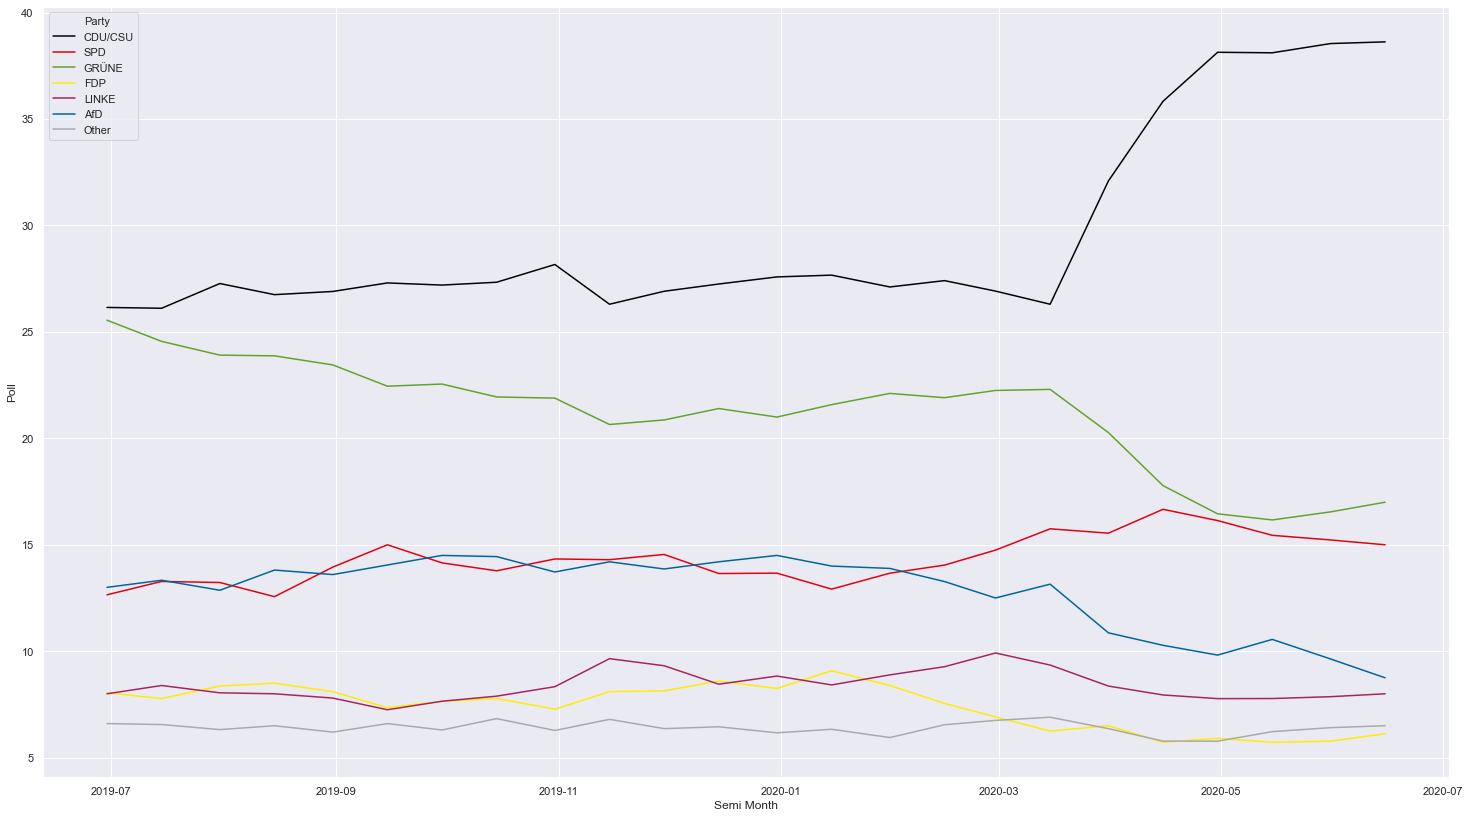

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

party_colors = {
    'CDU/CSU': '#000000', 
    'SPD': '#E3000F', 
    'GRÜNE': '#64A12D', 
    'FDP': '#ffed00', 
    'LINKE': '#A52460', 
    'AfD': '#006699', 
    'REP': '#8B4513',
    'PIRATEN': '#FF8800', 
    'Rechte': '#8B4513', 
    'Non-Voters': '#D3D3D3', 
    'FW': '#007E84', 
    'NPD': '#8B4513', 
    'KPD/DKP': '#ff0000', 
    'DRP': '#696969',
    'GB/BHE': '#696969', 
    'DP': '#696969', 
    'BP': '#696969', 
    'Zentrum': '#696969', 
    'Other': '#A9A9A9'
}

def polls_by(data, interval, start=None, end=None, drop_non_voters=True):
    frame = data.groupby(interval).mean().sort_index(ascending=False).head(24)
    if drop_non_voters:
        frame.drop(columns=['Non-Voters'], inplace=True)
    return frame.dropna(axis='columns', how='all')

agg_by = 'Semi Month'

df = polls_by(data, agg_by).reset_index()
cols = df.columns.values[1:]
df = pd.melt(df, id_vars=[agg_by], value_vars=cols,var_name='Party', value_name='Poll')

plt.rcParams['figure.figsize'] = [64/2.54, 36/2.54]
sns.set()
sns.lineplot(data=df,
            x=agg_by,
            y='Poll',
            hue='Party',
            palette=party_colors)
plt.plot()